## Ecrire la description du problème sur moment de flemme

In [112]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

In [136]:
def f1(x):
    return x**2

In [142]:
torch.manual_seed(0)
number_points = np.array([10, 50, 1e2, 250, 500, 1e3, 5000, 1e4, 1e5, 1e6, 1e7])
monte_carlo_estimation = np.array([])
trapz_estimation = np.array([])
np.set_printoptions(precision=15)

for n in number_points :
    # x = torch.rand(int(n))
    x = np.linspace(0, 1, int(n))
    y = f1(x)
    # monte_carlo_estimation = np.append(monte_carlo_estimation, torch.mean(y).item())
    trapz_estimation = np.append(trapz_estimation, trapz(y, x).item())


monte_carlo_error = np.abs(monte_carlo_estimation - 1/3)
trapz_error = np.abs(trapz_estimation - 1/3)
print(trapz_error)
# slope = np.diff(monte_carlo_estimation)/np.diff(number_points)

[2.057613168724326e-03 6.941552131062290e-05 1.700506751023401e-05
 2.688128686090252e-06 6.693413547309568e-07 1.670005007059494e-07
 6.669334140507743e-09 1.667000093519277e-09 1.666700111258024e-11
 1.666444759962360e-13 1.720845688168993e-15]


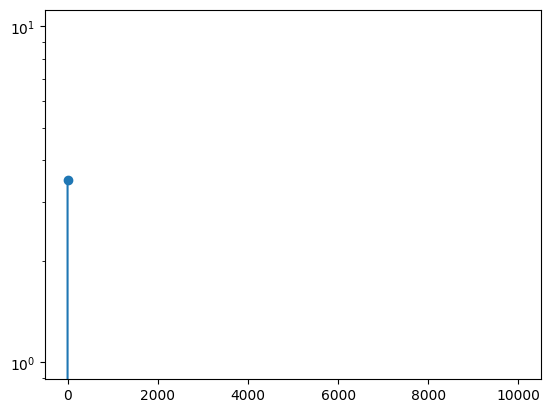

In [127]:
plt.plot(number_points, trapz_error, marker='o')
plt.yscale('log')
# for i in range(len(number_points) - 1):
#     x_mid = (number_points[i] + number_points[i+1])/2
#     y_mid = (monte_carlo_error[i] + monte_carlo_error[i+1])/2
#     plt.text(x_mid, y_mid, f'{slope[i]:.8f}', fontsize=12)
plt.show()

In [65]:
def u_exact(x):
    return 2 + x

def grad_u():
    return 2

In [66]:
nb_points = 4
omega = torch.linspace(0, 1, nb_points) # boundary included
sol = u_exact(omega)

In [67]:
# MODEL DEFINITION #

class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(in_features=m, out_features=m)
        # self.activation = torch.nn.Tanh()
        self.activation = lambda x: torch.maximum(x**3, torch.tensor(0.))

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_layer_dim, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(in_features=input_dim, out_features=hidden_layer_dim)
        self.blocks = torch.nn.ModuleList([Block(hidden_layer_dim) for _ in range(nb_blocks)])
        self.fc_out = torch.nn.Linear(hidden_layer_dim, 1)

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return x

In [195]:
class ActivationCube(torch.nn.Module):
    def __init__(self) -> None:
        super(ActivationCube, self).__init__()

    def forward(self, x):
        return torch.maximum(x**3, torch.tensor(0.))

class RitzModel(torch.nn.Module):

    def __init__(self):
        super(RitzModel, self).__init__()

        self.fc1 = torch.nn.Linear(in_features=1, out_features=10)
        self.activation1 = ActivationCube()
        self.fc2 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation2 = ActivationCube()

        self.fc3 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation3 = ActivationCube()
        self.fc4 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation4 = ActivationCube()

        self.fc5 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation5 = ActivationCube()
        self.fc6 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation6 = ActivationCube()

        self.fc7 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation7 = ActivationCube()
        self.fc8 = torch.nn.Linear(in_features=10, out_features=10)
        self.activation8 = ActivationCube()

        self.fc9 = torch.nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        retain_x1 = x
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = x + retain_x1

        retain_x2 = x
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = x + retain_x2

        retain_x3 = x
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = x + retain_x3

        retain_x4 = x
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = x + retain_x4

        u_theta = self.fc9(x)

        return u_theta

In [196]:
ritz_model = RitzModel()
print(ritz_model)
print(f'Le nombre de paramètres est {sum(p.numel() for p in ritz_model.parameters())}')

RitzModel(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (activation1): ActivationCube()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): ActivationCube()
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (activation3): ActivationCube()
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (activation4): ActivationCube()
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (activation5): ActivationCube()
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (activation6): ActivationCube()
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (activation7): ActivationCube()
  (fc8): Linear(in_features=10, out_features=10, bias=True)
  (activation8): ActivationCube()
  (fc9): Linear(in_features=10, out_features=1, bias=True)
)
Le nombre de paramètres est 801


In [147]:
num_epochs = 100
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999
gamma = 500

# MODEL INITIALIZATION #
gen = Model(input_dim=1, hidden_layer_dim=10, nb_blocks=1)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

for epoch in range(10):
    mc_omega = torch.rand(10000) 
    mc_omega_unsqueeze = mc_omega.unsqueeze(1) # we add a dimension to match the input dimension of the model
    mc_omega_unsqueeze.requires_grad = True

    boundary_left = torch.zeros(1).unsqueeze(1)
    boundary_right = torch.ones(1).unsqueeze(1)

    output_mc_omega = gen(mc_omega_unsqueeze)
    output_mc_boundary_left = gen(boundary_left)
    output_mc_boundary_right = gen(boundary_right)
    # print(output_mc_boundary_right)

    grad_output_mc = torch.ones_like(output_mc_omega)
    grad_output_mc = torch.autograd.grad(output_mc_omega, mc_omega_unsqueeze, grad_output_mc, create_graph=True)[0]

    l1 = 0.5 * torch.mean(grad_output_mc.square())
    l2 = gen(boundary_left) - 2 + gen(boundary_right) - 3
    l = l1 - l2

    gen_opt.zero_grad()
    l.backward()
    gen_opt.step()

[0. 0. 0. ... 0. 0. 0.]


RuntimeError: grad can be implicitly created only for scalar outputs

In [85]:
print(gen(omega.unsqueeze(1)))

tensor([[0.2813],
        [0.3227],
        [0.3625],
        [0.3960]], grad_fn=<AddmmBackward0>)
